## Import necessary libraries

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import pickle
import scipy.stats as stats
import scipy.sparse 

# Plotting
from matplotlib import pyplot as plt

# CatBoost
from catboost import CatBoostClassifier, Pool

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    recall_score, roc_auc_score, accuracy_score, matthews_corrcoef, 
    confusion_matrix, f1_score, precision_score, average_precision_score
)

## Data Loading

In [2]:
random_num = 1

df_5cls = pd.read_csv("data/df_87w_five_classes.csv")
print(df_5cls['targets'].value_counts())
print(df_5cls.shape)

df_pre, df_remain = train_test_split(df_5cls, test_size=0.2, stratify=df_5cls['targets'], random_state = random_num)
df_val, df_test = train_test_split(df_remain, test_size=0.5, stratify=df_remain['targets'], random_state = random_num)

print("Training set before fold split:", df_pre.shape)
print("Validation set:", df_val.shape)
print("Test set:", df_test.shape)

df_pre['targets'].value_counts()

label_info = df_pre['targets'].unique().tolist()
print("label_info", label_info)


1    300342
0    273315
2    180185
3     81183
4     41065
Name: targets, dtype: int64
(876090, 2)
Training set before fold split: (700872, 2)
Validation set: (87609, 2)
Test set: (87609, 2)
label_info [4, 1, 2, 0, 3]


In [3]:
# Extract indices from each split for the dictionary
training_indices = df_pre.index.tolist()
validation_indices = df_val.index.tolist()
testing_indices = df_test.index.tolist()

# Create a dictionary to store these indices
index_dict = {
    "training": training_indices,
    "validation": validation_indices,
    "testing": testing_indices
}

# Optional: Save this dictionary to a JSON file
import json
with open('data/split/df_87w_five_classes.json', 'w') as f:
    json.dump(index_dict, f)

print("Index dictionary saved to 'data/split/df_87w_five_classes.json'")

Index dictionary saved to 'data/split/df_87w_five_classes.json'


## Split data into multi-folds based on data distribution

In [4]:
min_fold_size = min(df_pre['targets'].value_counts())
print("min_fold_size", min_fold_size)

min_fold_size 32852


In [5]:
def fold_split(df, fold_num):
    # Calculate the minimum fold size for each label
    min_fold_size = min(df['targets'].value_counts())
    print("min_fold_size", min_fold_size)
    
    # Initialize an empty dictionary to store the split indices for each label
    label_splits = {}

    # Iterate over each unique label
    for label_value in df['targets'].unique():
        label_indices = np.where(df['targets'] == label_value)[0]
        label_size = len(label_indices)
        
        # Calculate the fold size for this label
        fold_size = label_size // fold_num
        
        # If the label's size divided by fold_num is greater than or equal to the minimum fold size, perform equal split
        if fold_size >= min_fold_size:
            fold_indices = []
            for i in range(fold_num - 1):
                start_index = i * fold_size
                end_index = start_index + fold_size
                fold = label_indices[start_index:end_index]
                fold_indices.append(fold)

            # Add the remaining indices to the last fold
            start_index = (fold_num - 1) * fold_size
            fold = label_indices[start_index:]
            fold_indices.append(fold)

        # If the label's size divided by fold_num is less than the minimum fold size, randomly sample min_fold_size indices
        elif fold_size < min_fold_size:
            fold_indices = []
            for _ in range(fold_num):
                sampled_indices = np.random.choice(label_indices, min_fold_size, replace=False)
                fold_indices.append(sampled_indices)
        
        # If the label's size divided by fold_num is less than the minimum fold size, allow partial overlap
        else:
            overlap_size = label_size % fold_num
            fold_size_with_overlap = fold_size + 1
            fold_indices = [label_indices[i:i+fold_size_with_overlap] for i in range(0, label_size-overlap_size, fold_size_with_overlap)]
        
        # Store the fold indices for this label
        label_splits[label_value] = fold_indices

    return label_splits

In [6]:
fold_num = 6
fold_splits = fold_split(df_pre, fold_num)
# print fold size
for label_value, label_folds in fold_splits.items():
    print(f"For label {label_value}:")
    for i, fold in enumerate(label_folds):
        print(f"\tFold {i+1}: {len(fold)}")


min_fold_size 32852
For label 4:
	Fold 1: 32852
	Fold 2: 32852
	Fold 3: 32852
	Fold 4: 32852
	Fold 5: 32852
	Fold 6: 32852
For label 1:
	Fold 1: 40045
	Fold 2: 40045
	Fold 3: 40045
	Fold 4: 40045
	Fold 5: 40045
	Fold 6: 40049
For label 2:
	Fold 1: 32852
	Fold 2: 32852
	Fold 3: 32852
	Fold 4: 32852
	Fold 5: 32852
	Fold 6: 32852
For label 0:
	Fold 1: 36442
	Fold 2: 36442
	Fold 3: 36442
	Fold 4: 36442
	Fold 5: 36442
	Fold 6: 36442
For label 3:
	Fold 1: 32852
	Fold 2: 32852
	Fold 3: 32852
	Fold 4: 32852
	Fold 5: 32852
	Fold 6: 32852


In [7]:
# Initialize an empty list of fold_num elements to store each individual fold
folds = [[] for _ in range(fold_num)]

# Iterate through the folds for each label
for label_folds in fold_splits.values():
    # Add each label's fold to the corresponding fold
    for i, fold in enumerate(label_folds):
        folds[i].extend(fold)

# Print the length of each individual fold
for i, fold in enumerate(folds):
    print(f"Fold {i+1} length:", len(fold))

Fold 1 length: 175043
Fold 2 length: 175043
Fold 3 length: 175043
Fold 4 length: 175043
Fold 5 length: 175043
Fold 6 length: 175047


In [8]:
# Create a new DataFrame for each fold using the indices from df_pre
dfs = []
for i, fold_indices in enumerate(folds):
    df_fold = df_pre.iloc[fold_indices]
    print(df_fold['targets'].value_counts())  # Print the value counts of the 'targets' column
    dfs.append(df_fold)

# Print the length of each new DataFrame
for i, df_fold in enumerate(dfs):
    print(f"DataFrame {i+1} length:", len(df_fold))

1    40045
0    36442
4    32852
2    32852
3    32852
Name: targets, dtype: int64
1    40045
0    36442
4    32852
2    32852
3    32852
Name: targets, dtype: int64
1    40045
0    36442
4    32852
2    32852
3    32852
Name: targets, dtype: int64
1    40045
0    36442
4    32852
2    32852
3    32852
Name: targets, dtype: int64
1    40045
0    36442
4    32852
2    32852
3    32852
Name: targets, dtype: int64
1    40049
0    36442
4    32852
2    32852
3    32852
Name: targets, dtype: int64
DataFrame 1 length: 175043
DataFrame 2 length: 175043
DataFrame 3 length: 175043
DataFrame 4 length: 175043
DataFrame 5 length: 175043
DataFrame 6 length: 175047


## Training by folds
The training data are converted to morgan fingerprints and prestored as "87w_morgan.npz" by notebook 1.

In [9]:
df_pre.iloc[1]

# Load features
fp_87w = scipy.sparse.load_npz('feature/87w_morgan.npz')

# Training set
x_train0 = fp_87w[list(dfs[0].index)]
y_train0 = dfs[0]['targets']

x_train1 = fp_87w[list(dfs[1].index)]
y_train1 = dfs[1]['targets']

x_train2 = fp_87w[list(dfs[2].index)]
y_train2 = dfs[2]['targets']

x_train3 = fp_87w[list(dfs[3].index)]
y_train3 = dfs[3]['targets']

x_train4 = fp_87w[list(dfs[4].index)]
y_train4 = dfs[4]['targets']

x_train5 = fp_87w[list(dfs[5].index)]
y_train5 = dfs[5]['targets']


# Testing set
x_test = fp_87w[list(df_test.index)]
y_test = df_test['targets']

print("Dimension check:")
print("x_train0", x_train0.shape, "y_train0", y_train0.shape)
print("y_train0 counts:", np.unique(y_train0, return_counts=True))
print("x_train1", x_train1.shape, "y_train0", y_train1.shape)
print("y_train1 counts:", np.unique(y_train1, return_counts=True))
print("x_train2", x_train2.shape, "y_train0", y_train2.shape)
print("y_train2 counts:", np.unique(y_train2, return_counts=True))
print("x_train3", x_train3.shape, "y_train0", y_train3.shape)
print("y_train3 counts:", np.unique(y_train3, return_counts=True))
print("x_train4", x_train4.shape, "y_train0", y_train4.shape)
print("y_train4 counts:", np.unique(y_train4, return_counts=True))
print("x_train5", x_train5.shape, "y_train0", y_train5.shape)
print("y_train5 counts:", np.unique(y_train5, return_counts=True))


print("y_test counts:", np.unique(y_test, return_counts=True))

Dimension check:
x_train0 (175043, 1024) y_train0 (175043,)
y_train0 counts: (array([0, 1, 2, 3, 4]), array([36442, 40045, 32852, 32852, 32852]))
x_train1 (175043, 1024) y_train0 (175043,)
y_train1 counts: (array([0, 1, 2, 3, 4]), array([36442, 40045, 32852, 32852, 32852]))
x_train2 (175043, 1024) y_train0 (175043,)
y_train2 counts: (array([0, 1, 2, 3, 4]), array([36442, 40045, 32852, 32852, 32852]))
x_train3 (175043, 1024) y_train0 (175043,)
y_train3 counts: (array([0, 1, 2, 3, 4]), array([36442, 40045, 32852, 32852, 32852]))
x_train4 (175043, 1024) y_train0 (175043,)
y_train4 counts: (array([0, 1, 2, 3, 4]), array([36442, 40045, 32852, 32852, 32852]))
x_train5 (175047, 1024) y_train0 (175047,)
y_train5 counts: (array([0, 1, 2, 3, 4]), array([36442, 40049, 32852, 32852, 32852]))
y_test counts: (array([0, 1, 2, 3, 4]), array([27331, 30034, 18018,  8119,  4107]))


In [10]:
# Define common parameters for the CatBoost classifiers and fit the base models
common_params = {
    'n_estimators': 4000,
    'learning_rate': 0.15,
    'l2_leaf_reg': 0.5,
    'depth': 4,
    'loss_function': 'MultiClass',
    'eval_metric': 'Accuracy',
    'random_seed': 42
}

# Create individual CatBoost classifier models
catboost_model0 = CatBoostClassifier(**common_params)
catboost_model1 = CatBoostClassifier(**common_params)
catboost_model2 = CatBoostClassifier(**common_params)
catboost_model3 = CatBoostClassifier(**common_params)
catboost_model4 = CatBoostClassifier(**common_params)
catboost_model5 = CatBoostClassifier(**common_params)

catboost_model0.fit(x_train0, y_train0, eval_set=(x_test, y_test), verbose=500)
catboost_model1.fit(x_train1, y_train1, eval_set=(x_test, y_test), verbose=500)
catboost_model2.fit(x_train2, y_train2, eval_set=(x_test, y_test), verbose=500)
catboost_model3.fit(x_train3, y_train3, eval_set=(x_test, y_test), verbose=500)
catboost_model4.fit(x_train4, y_train4, eval_set=(x_test, y_test), verbose=500)
catboost_model5.fit(x_train5, y_train5, eval_set=(x_test, y_test), verbose=500)

In [11]:
# Save models

with open('model/fold6/catboost_morgan_fold0.pkl', 'wb') as f:
    pickle.dump(catboost_model0, f)
    
with open('model/fold6/catboost_morgan_fold1.pkl', 'wb') as f:
    pickle.dump(catboost_model1, f)
    
with open('model/fold6/catboost_morgan_fold2.pkl', 'wb') as f:
    pickle.dump(catboost_model2, f)
    
with open('model/fold6/catboost_morgan_fold3.pkl', 'wb') as f:
    pickle.dump(catboost_model3, f)
    
with open('model/fold6/catboost_morgan_fold4.pkl', 'wb') as f:
    pickle.dump(catboost_model4, f)
    
with open('model/fold6/catboost_morgan_fold5.pkl', 'wb') as f:
    pickle.dump(catboost_model5, f)

In [12]:
## Load models
with open('model/fold6/catboost_morgan_fold0.pkl', 'rb') as f:
    catboost_model0 = pickle.load(f)
    
with open('model/fold6/catboost_morgan_fold1.pkl', 'rb') as f:
    catboost_model1 = pickle.load(f)
    
with open('model/fold6/catboost_morgan_fold2.pkl', 'rb') as f:
    catboost_model2 = pickle.load(f)
    
with open('model/fold6/catboost_morgan_fold3.pkl', 'rb') as f:
    catboost_model3 = pickle.load(f)
    
with open('model/fold6/catboost_morgan_fold4.pkl', 'rb') as f:
    catboost_model4 = pickle.load(f)
    
with open('model/fold6/catboost_morgan_fold5.pkl', 'rb') as f:
    catboost_model5 = pickle.load(f)


In [13]:
def evaluate_res(model, test_pool, y_test, n_class):

    # Make predictions
    y_test_pred_prob = model.predict_proba(test_pool)
    pred = model.predict(test_pool)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, pred)
    mcc = matthews_corrcoef(y_test, pred)
    recall = recall_score(y_test, pred, average='macro')
    precision_score_value = precision_score(y_test, pred, average='macro')
    f1_macro = f1_score(y_test, pred, average='macro')
    f1_micro = f1_score(y_test, pred, average='micro')
    f1_weighted = f1_score(y_test, pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr')

    # Calculate PR AUC for each class and average it
    pr_auc = np.mean([
        average_precision_score(y_test == i, y_test_pred_prob[:, i])
        for i in range(n_class)
    ])
    
    confusion_mat = confusion_matrix(y_test, pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(n_class)
    plt.xticks(tick_marks, ["={}".format(i+1) if i < 4 else ">4" for i in range(n_class)], fontsize=16)
    plt.yticks(tick_marks, ["={}".format(i+1) if i < 4 else ">4" for i in range(n_class)], fontsize=16)
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

    for i in range(n_class):
        for j in range(n_class):
            plt.text(j, i, confusion_mat[i, j], ha='center', va='center', fontsize=16,
                     color="white" if confusion_mat[i, j] > np.max(confusion_mat) / 2 else "black")

    plt.tight_layout()
    plt.show()

    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("MCC:", mcc)
    print("Recall:", recall)
    print("Precision:", precision_score_value)
    print("F1 Score (Macro):", f1_macro)
    print("F1 Score (Micro):", f1_micro)
    print("F1 Score (Weighted):", f1_weighted)
    print("ROC AUC:", roc_auc)
    print("PR AUC:", pr_auc)
    
    return confusion_mat


Model 0:


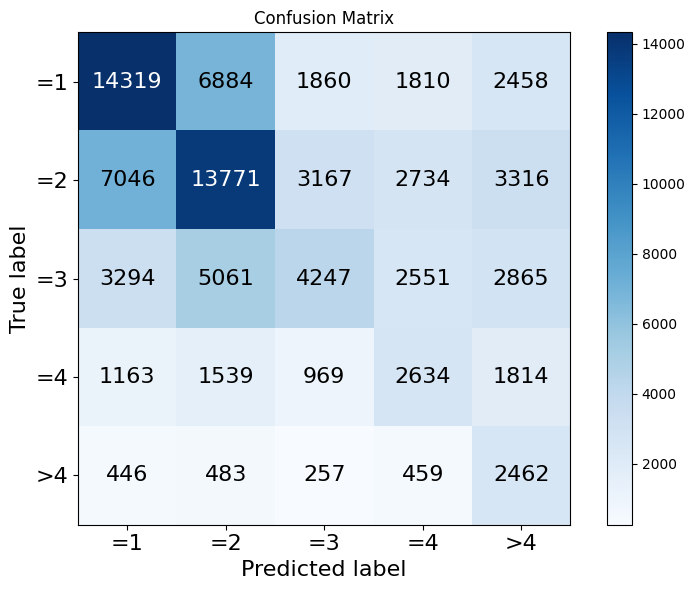

Accuracy: 0.4272734536406077
MCC: 0.245112738207876
Recall: 0.42840430345943076
Precision: 0.3790451123483154
F1 Score (Macro): 0.37718312175517854
F1 Score (Micro): 0.4272734536406077
F1 Score (Weighted): 0.4316022028640336
ROC AUC: 0.7302897804386543
PR AUC: 0.40039997710444686
Model 1:


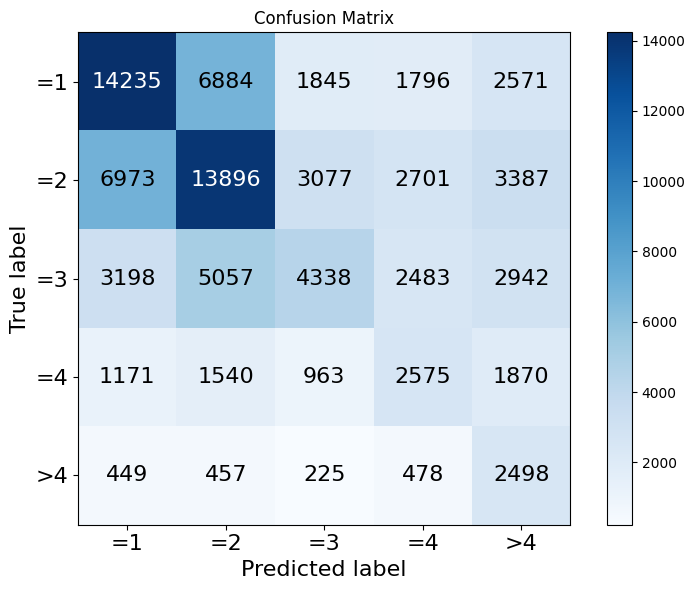

Accuracy: 0.42851761805293975
MCC: 0.24751345117112714
Recall: 0.4299318313055509
Precision: 0.38126464710907704
F1 Score (Macro): 0.3779761348496184
F1 Score (Micro): 0.42851761805293975
F1 Score (Weighted): 0.43355670682496567
ROC AUC: 0.7304584901564155
PR AUC: 0.40004586931377856
Model 2:


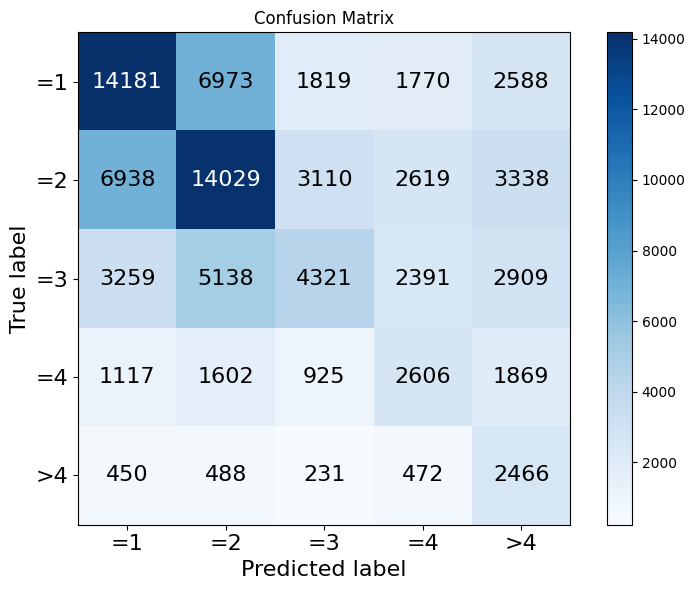

Accuracy: 0.4292138935497495
MCC: 0.24744111897628887
Recall: 0.4294389641188312
Precision: 0.3820743329800821
F1 Score (Macro): 0.378671506525869
F1 Score (Micro): 0.4292138935497495
F1 Score (Weighted): 0.43394844605024563
ROC AUC: 0.7314852892315787
PR AUC: 0.40105501291623363
Model 3:


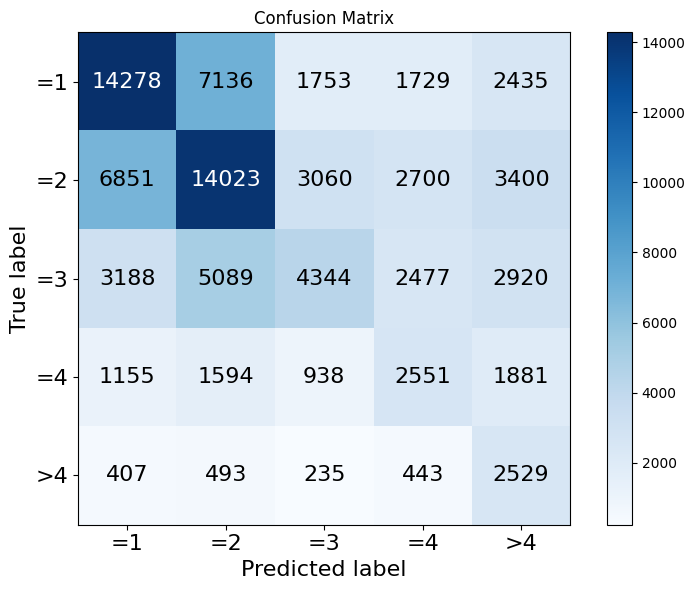

Accuracy: 0.4306064445433688
MCC: 0.24929169374658505
Recall: 0.4320772124894844
Precision: 0.3833843111597044
F1 Score (Macro): 0.37992538971479706
F1 Score (Micro): 0.4306064445433688
F1 Score (Weighted): 0.4351432490086985
ROC AUC: 0.7316238605460631
PR AUC: 0.4016555285286131
Model 4:


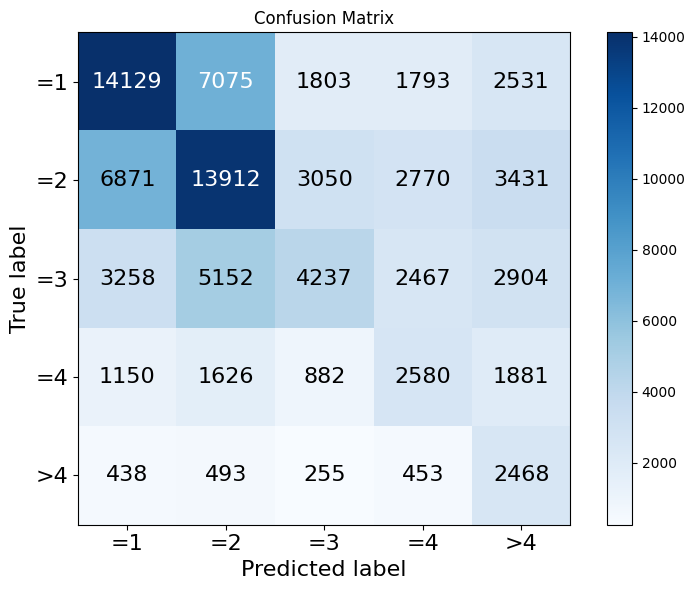

Accuracy: 0.42605211793308906
MCC: 0.2437250132231744
Recall: 0.4268038476247189
Precision: 0.37928389831159076
F1 Score (Macro): 0.37549732747835796
F1 Score (Micro): 0.42605211793308906
F1 Score (Weighted): 0.4307731233786072
ROC AUC: 0.7299218687017922
PR AUC: 0.40016601567780075
Model 5:


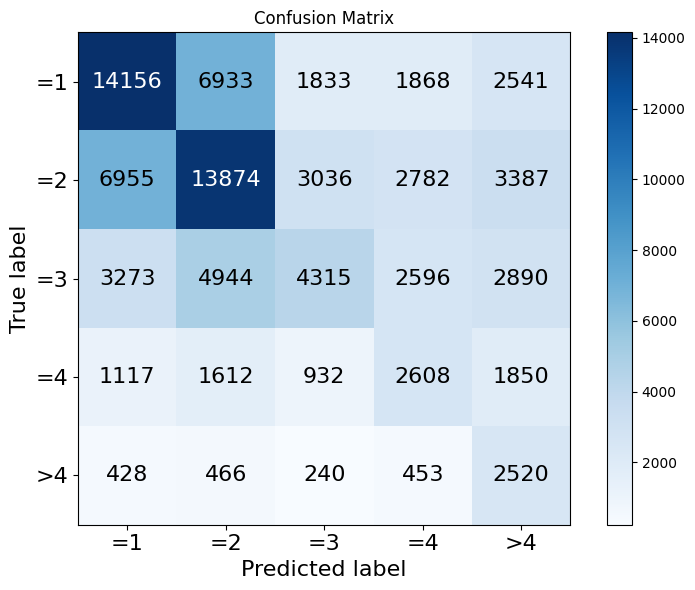

Accuracy: 0.42773002773687635
MCC: 0.24682563805650226
Recall: 0.43083618189278355
Precision: 0.38105569627446795
F1 Score (Macro): 0.3779542178687832
F1 Score (Micro): 0.42773002773687635
F1 Score (Weighted): 0.4326803392599587
ROC AUC: 0.7302126891182202
PR AUC: 0.4013299583091177


In [14]:

test_pool = Pool(data=x_test, label=y_test)

def evaluate_res(model, test_pool, y_test, n_class):
    # Make predictions
    y_test_pred_prob = model.predict_proba(test_pool)
    pred = model.predict(test_pool)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, pred)
    mcc = matthews_corrcoef(y_test, pred)
    recall = recall_score(y_test, pred, average='macro')
    precision_score_value = precision_score(y_test, pred, average='macro')
    f1_macro = f1_score(y_test, pred, average='macro')
    f1_micro = f1_score(y_test, pred, average='micro')
    f1_weighted = f1_score(y_test, pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr')

    # Calculate PR AUC for each class and average it
    pr_auc = np.mean([
        average_precision_score(y_test == i, y_test_pred_prob[:, i])
        for i in range(n_class)
    ])
    
    confusion_mat = confusion_matrix(y_test, pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(n_class)
    plt.xticks(tick_marks, ["={}".format(i+1) if i < 4 else ">4" for i in range(n_class)], fontsize=16)
    plt.yticks(tick_marks, ["={}".format(i+1) if i < 4 else ">4" for i in range(n_class)], fontsize=16)
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

    for i in range(n_class):
        for j in range(n_class):
            plt.text(j, i, confusion_mat[i, j], ha='center', va='center', fontsize=16,
                     color="white" if confusion_mat[i, j] > np.max(confusion_mat) / 2 else "black")

    plt.tight_layout()
    plt.show()

    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("MCC:", mcc)
    print("Recall:", recall)
    print("Precision:", precision_score_value)
    print("F1 Score (Macro):", f1_macro)
    print("F1 Score (Micro):", f1_micro)
    print("F1 Score (Weighted):", f1_weighted)
    print("ROC AUC:", roc_auc)
    print("PR AUC:", pr_auc)
    
    return {
        "Accuracy": accuracy,
        "MCC": mcc,
        "Recall": recall,
        "Precision": precision_score_value,
        "F1 Score (Macro)": f1_macro,
        "F1 Score (Micro)": f1_micro,
        "F1 Score (Weighted)": f1_weighted,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc
    }

# Evaluate models and collect metrics
metrics_list = []
models = [catboost_model0, catboost_model1, catboost_model2, catboost_model3, catboost_model4, catboost_model5]

for i, model in enumerate(models):
    print(f"Model {i}:")
    metrics = evaluate_res(model, test_pool, y_test, n_class=5)
    metrics_list.append(metrics)


### Evaluation

In [15]:
def most_common_vote(all_pred):
    # Calculate the most common value in each row
    most_common_per_row = np.apply_along_axis(lambda row: np.bincount(row).argmax(), axis=1, arr=all_pred)
    
    # Reshape into a 1D array of length 10000
    result = most_common_per_row.reshape(-1,).tolist()  # Convert to list without inner lists
    
    # Calculate the frequency of each number in each row
    frequencies = {}
    for i, row in enumerate(all_pred):
        row_freq = {}
        unique, counts = np.unique(row, return_counts=True)
        for num, count in zip(unique, counts):
            row_freq[num] = count
        frequencies[i] = row_freq
    
    return result, frequencies


def average_best(sum_pred_prob):
    # Find the index of the maximum value in each row
    max_index_per_row = np.argmax(sum_pred_prob, axis=1)
    
    # Flatten the array to 1D
    result = max_index_per_row.flatten()
    max_prob = np.max(sum_pred_prob, axis=1)
    
    return result, max_prob


In [16]:
def aggregation(models, test_pool, n_class, agg_type, title):
    # make predictions
    y_test = test_pool.get_label().astype(int)  # Ensure y_test is integer
    
    # sum up all the prediction probabilities / concatenate all the prediction results
    sum_pred_prob = models[0].predict_proba(test_pool) # (data_size, class_size) e.g. (10000, 5)
    all_pred = models[0].predict(test_pool).astype(int)  # Ensure all_pred is integer

    for i in range(1, len(models)):
        sum_pred_prob += models[i].predict_proba(test_pool)
        all_pred = np.hstack([all_pred, models[i].predict(test_pool).astype(int)])  # Ensure all_pred is integer
    print("pred", all_pred.shape)
    print("y_test_pred_prob", sum_pred_prob.shape)
    
    if agg_type == "max":
        y_test_pred_prob = sum_pred_prob / len(models)
        _, pred_probability = average_best(sum_pred_prob)

        pred, frequencies = most_common_vote(all_pred)
        
    elif agg_type == "avg":
        y_test_pred_prob = sum_pred_prob / len(models)
        pred, pred_probability = average_best(sum_pred_prob)
        pred = pred.astype(int)  # Ensure pred is integer
    else:
        print(f"No such method: {agg_type}")

    
    print("pred_probability", pred_probability.shape)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, pred)
    mcc = matthews_corrcoef(y_test, pred)
    recall = recall_score(y_test, pred, average='macro')
    precision_score_value = precision_score(y_test, pred, average='macro')
    f1_macro = f1_score(y_test, pred, average='macro')
    f1_micro = f1_score(y_test, pred, average='micro')
    f1_weighted = f1_score(y_test, pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr')

    # Calculate PR AUC for each class and average it
    pr_auc = np.mean([
        average_precision_score(y_test == i, y_test_pred_prob[:, i])
        for i in range(n_class)
    ])
    
    confusion_mat = confusion_matrix(y_test, pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(n_class)
    plt.xticks(tick_marks, ["={}".format(i+1) if i < 4 else ">4" for i in range(n_class)], fontsize=16)
    plt.yticks(tick_marks, ["={}".format(i+1) if i < 4 else ">4" for i in range(n_class)], fontsize=16)
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

    for i in range(n_class):
        for j in range(n_class):
            plt.text(j, i, confusion_mat[i, j], ha='center', va='center', fontsize=16, 
                     color="white" if confusion_mat[i, j] > np.max(confusion_mat) / 2 else "black")

    plt.tight_layout()
    plt.show()

    # Error calculation
    errors = pred - y_test
    mean_error = np.mean(errors)
    median_error = np.median(errors)
    std_error = np.std(errors)
    skewness_error = stats.skew(errors)
    kurtosis_error = stats.kurtosis(errors)

    print("errors", errors)
    # Plotting the error distribution using a histogram
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=np.arange(errors.min(), errors.max() + 1) - 0.5, edgecolor='k', alpha=0.7)
    plt.title(title)
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Printing summary statistics
    print("Error Summary Statistics:")
    print(f"Mean Error: {mean_error}")
    print(f"Median Error: {median_error}")
    print(f"Standard Deviation of Error: {std_error}")
    print(f"Skewness of Error: {skewness_error}")
    print(f"Kurtosis of Error: {kurtosis_error}")

    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("MCC:", mcc)
    print("Recall:", recall)
    print("Precision:", precision_score_value)
    print("F1 Score (Macro):", f1_macro)
    print("F1 Score (Micro):", f1_micro)
    print("F1 Score (Weighted):", f1_weighted)
    print("ROC AUC:", roc_auc)
    print("PR AUC:", pr_auc)
    print("Final Confusion Matrix:\n", confusion_mat)
    
    return confusion_mat, y_test, pred, y_test_pred_prob, errors

# Example usage:
# aggregation(models, test_pool, n_class=5, agg_type='avg')

### Probability Aggregation (PA)

pred (87609, 6)
y_test_pred_prob (87609, 5)
pred_probability (87609,)


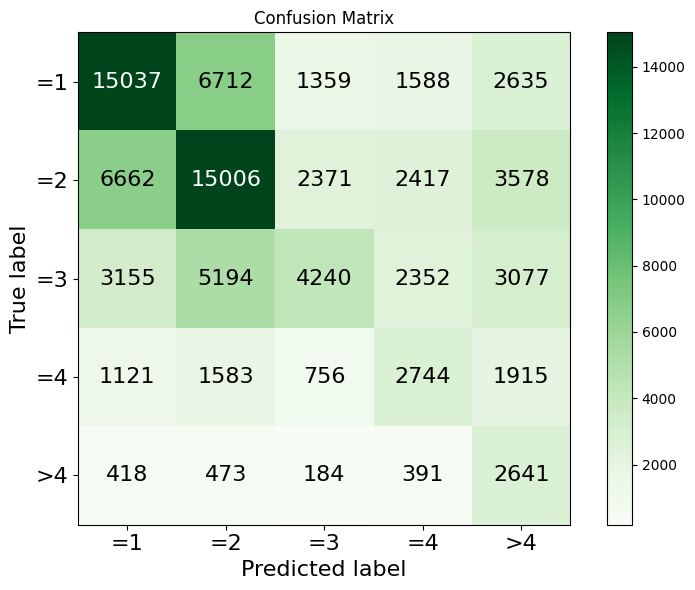

errors [-1  2  0 ...  1 -1 -2]


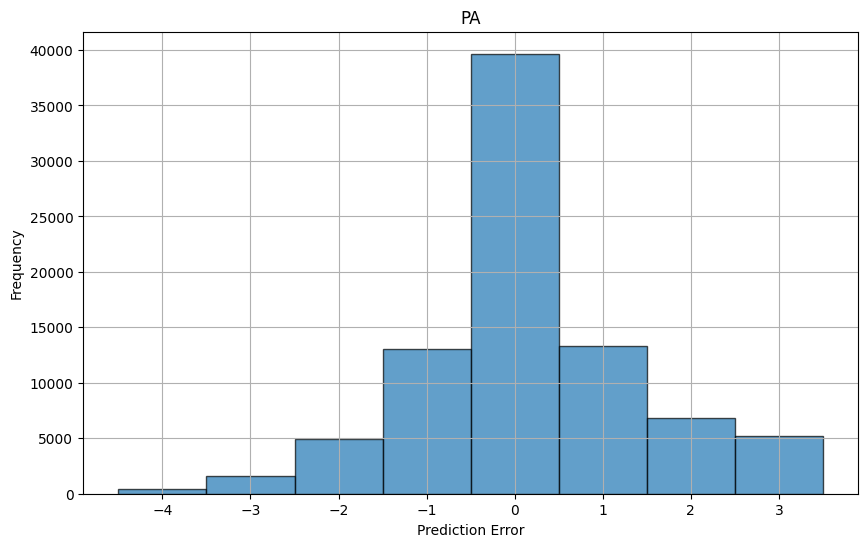

Error Summary Statistics:
Mean Error: 0.27158168681299866
Median Error: 0.0
Standard Deviation of Error: 1.4200983421954336
Skewness of Error: 0.4321352228560496
Kurtosis of Error: 0.7816811390148555
Accuracy: 0.45278453126961843
MCC: 0.2789412627093653
Recall: 0.45323124147018545
Precision: 0.4086901292883516
F1 Score (Macro): 0.39783954221343
F1 Score (Micro): 0.45278453126961843
F1 Score (Weighted): 0.456450546047659
ROC AUC: 0.7524006356767278
PR AUC: 0.4300619555642643
Final Confusion Matrix:
 [[15037  6712  1359  1588  2635]
 [ 6662 15006  2371  2417  3578]
 [ 3155  5194  4240  2352  3077]
 [ 1121  1583   756  2744  1915]
 [  418   473   184   391  2641]]


array([[15037,  6712,  1359,  1588,  2635],
       [ 6662, 15006,  2371,  2417,  3578],
       [ 3155,  5194,  4240,  2352,  3077],
       [ 1121,  1583,   756,  2744,  1915],
       [  418,   473,   184,   391,  2641]])

In [17]:
model_lists = [catboost_model0, catboost_model1, catboost_model2, catboost_model3, catboost_model4, catboost_model5]
# aggregation(model_lists, test_pool, n_class=5, agg_type = "max")
# confusion_matrix_prob, y_test_prob, pred_prob = aggregation(model_lists, test_pool, n_class=5, agg_type = "avg")
confusion_matrix_prob, y_test_pa, pred_pa, pred_prob_pa, errors_pa = aggregation(model_lists, test_pool, n_class=5, agg_type = "avg",title= "PA")
confusion_matrix_prob


### Voting aggregation

pred (87609, 6)
y_test_pred_prob (87609, 5)
pred_probability (87609,)


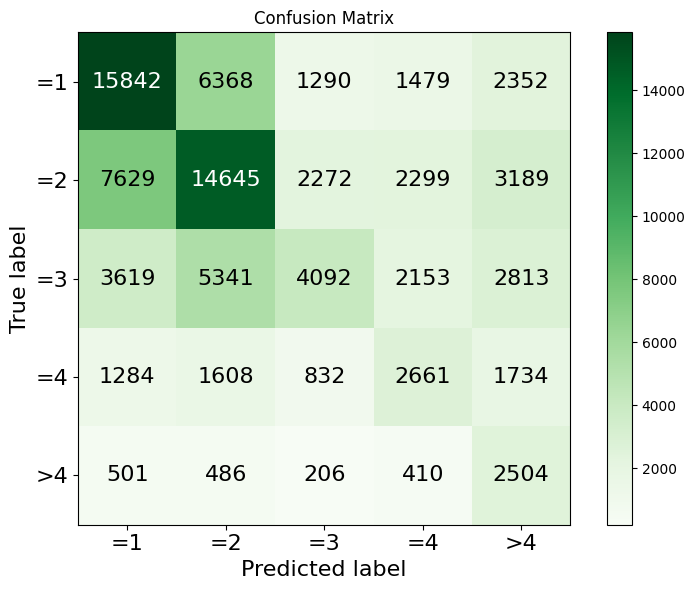

errors [-1  2  0 ...  1 -1 -2]


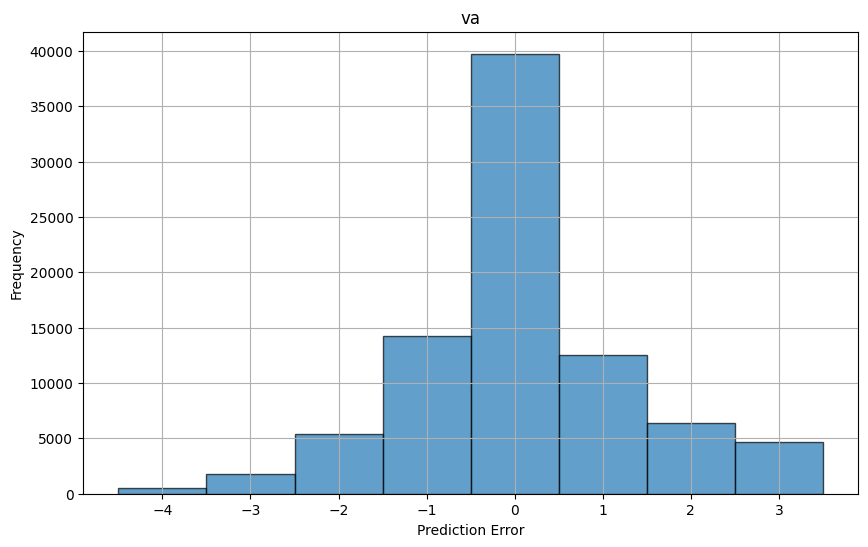

Error Summary Statistics:
Mean Error: 0.18663607620221667
Median Error: 0.0
Standard Deviation of Error: 1.4117873610458134
Skewness of Error: 0.42364395798107324
Kurtosis of Error: 0.8885955523810094
Accuracy: 0.45365202205252886
MCC: 0.27469717177551706
Recall: 0.44635912122657223
Precision: 0.4057349490005113
F1 Score (Macro): 0.39633930940246576
F1 Score (Micro): 0.4536520220525289
F1 Score (Weighted): 0.4534371461402275
ROC AUC: 0.7524006356767278
PR AUC: 0.4300619555642643
Final Confusion Matrix:
 [[15842  6368  1290  1479  2352]
 [ 7629 14645  2272  2299  3189]
 [ 3619  5341  4092  2153  2813]
 [ 1284  1608   832  2661  1734]
 [  501   486   206   410  2504]]


In [18]:
model_lists = [catboost_model0, catboost_model1, catboost_model2, catboost_model3, catboost_model4, catboost_model5]
# confusion_matrix_vot, y_test_vot, pred_vot = aggregation(model_lists, test_pool, n_class=5, agg_type = "max")
confusion_matrix_vot, y_test_va, pred_va, pred_prob_va, errors_va = aggregation(model_lists, test_pool, n_class=5, agg_type = "max", title = "va")


## Error Distribution


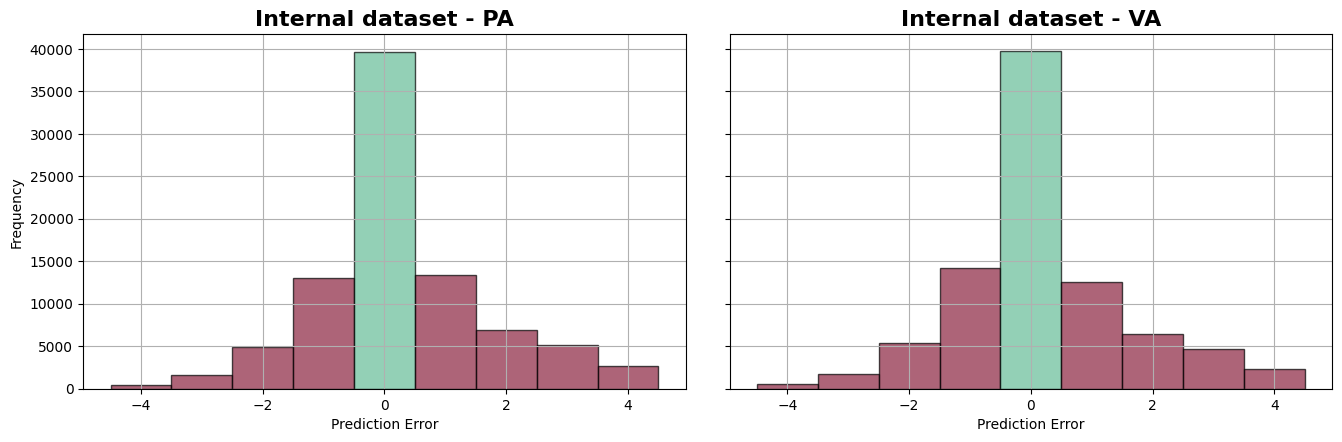

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_error_histograms(errors_pa, errors_va):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    # Font size adjustments
    plt.rc('font', size=14)         # Default text size
    plt.rc('axes', titlesize=16)    # Axes title size
    plt.rc('axes', labelsize=14)    # Axes label size
    plt.rc('xtick', labelsize=12)   # X-tick label size
    plt.rc('ytick', labelsize=12)   # Y-tick label size

    # Define colors
    zero_error_color = '#66BC98'
    other_error_color =  '#8A233F'
    
    # Plot for errors_pa
    counts_pa, bins_pa, patches_pa = axes[0].hist(errors_pa, bins=np.arange(errors_pa.min(), errors_pa.max() + 2) - 0.5, edgecolor='k', alpha=0.7)
    for patch, bin_center in zip(patches_pa, 0.5 * (bins_pa[:-1] + bins_pa[1:])):
        if bin_center == 0:
            patch.set_facecolor(zero_error_color)
        else:
            patch.set_facecolor(other_error_color)
    axes[0].set_title('Internal dataset - PA', fontweight='bold')
    axes[0].set_xlabel('Prediction Error')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True)

    # Plot for errors_va
    counts_va, bins_va, patches_va = axes[1].hist(errors_va, bins=np.arange(errors_va.min(), errors_va.max() + 2) - 0.5, edgecolor='k', alpha=0.7)
    for patch, bin_center in zip(patches_va, 0.5 * (bins_va[:-1] + bins_va[1:])):
        if bin_center == 0:
            patch.set_facecolor(zero_error_color)
        else:
            patch.set_facecolor(other_error_color)
    axes[1].set_title('Internal dataset - VA', fontweight='bold')
    axes[1].set_xlabel('Prediction Error')
    axes[1].grid(True)

    plt.tight_layout(pad=2.0)
    plt.show()


plot_error_histograms(errors_pa, errors_va)